In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import math

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import Phrases
from gensim.models import CoherenceModel

import spacy
import en_core_web_lg

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

from pprint import pprint

# 1. Data Source

<img src="images/Image 065.png">,

Here is to demonstrate how we can label data automatically

##### Compliance
1. **Compliance-related websites** (including SEC, WSJ complinace, The FCPA Blog, Corporate Compliance Insights, Compliance and Enforcement, Financial Services Perspectives)
2. **Google News** (Search for some compliance keywords, such as 15c3-5, insider trading, Consumer Protection Act) 

##### Non-compliance
<!-- list-start: 3 -->
3. **Google News** (Search for some finance keywords with broad topics, like cybersecurity, market structure)

In [4]:
# Import three data sources and give them labels
# Not compliance articles
google_news_finance = pd.read_excel('data/google_news_finance_1021.xlsx')
google_news_finance['text'] = google_news_finance['title'] + '. ' + google_news_finance['summary']
google_news_finance['class'] = 'Non-Compliance'
google_news_finance.loc[google_news_finance['keyword'] == 'compliance', 'class'] = 'Compliance'

# Compliance articles
google_news1 = pd.read_csv('data/Google_news_15c3-5.csv')
google_news1['text'] = google_news1['title'] + '. ' + google_news1['summary']
google_news1['class'] = 'Compliance'

google_news2 = pd.read_csv('data/google_news_1021.csv')
google_news2['text'] = google_news2['title'] + '. ' + google_news2['summary']
google_news2['class'] = 'Compliance'

# Compliance articles
df = pd.read_excel('data/NewsPaper_df.xlsx')
df['text'] = df['Title'] + '. ' + df['Summary']
df['class'] = 'Compliance'

In [5]:
# Combine three data sources into a single dataframe
news_df = pd.concat([google_news_finance[['text', 'class']], google_news1[['text', 'class']], google_news2[['text', 'class']], df[['text', 'class']]], ignore_index=True).dropna()
news_df.head()

,text,class
0,USOPC Announces Hiring Of Holly Shick As First...,Compliance
1,OPEC+ data reveals extent of oil quota non-com...,Compliance
2,"Nevada OSHA issues 11 workplace citations, 9 f...",Compliance
3,St. Paul’s School compliance officer abruptly ...,Compliance
4,Australia's Westpac reveals findings from comp...,Compliance


### Preproces texts

In [6]:
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
    return norm_papers

tokenized_docs = normalize_corpus(news_df.loc[news_df['class'] == 'Compliance', 'text'])
print(len(tokenized_docs))

691


# 2. Topic Modeling

<img src="images/Image 064.png">

### Create Bigram Corpus

In [7]:
bigram = Phrases(tokenized_docs, min_count=3, threshold=5)
bigram_texts = [bigram[line] for line in tokenized_docs]

id2word = Dictionary(bigram_texts)
print('Total Vocabulary Size (Before):', len(id2word))
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=15, no_above=0.6)
print('Total Vocabulary Size (After):', len(id2word))

corpus = [id2word.doc2bow(line) for line in bigram_texts]

Total Vocabulary Size (Before): 8876
Total Vocabulary Size (After): 528


### Build LDA Model

In [16]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         random_state=100,
                         num_topics=5,
                         passes=10,
                         chunksize=len(bigram_texts),
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.019*"ha" + 0.016*"said" + 0.014*"fund" + 0.013*"sec" + 0.011*"would" + '
  '0.010*"market" + 0.010*"security" + 0.010*"investor" + 0.010*"wa" + '
  '0.009*"bank"'),
 (1,
  '0.018*"company" + 0.014*"said" + 0.013*"compliance" + 0.013*"ha" + '
  '0.012*"wa" + 0.012*"data" + 0.011*"bank" + 0.009*"report" + 0.008*"also" + '
  '0.008*"case"'),
 (2,
  '0.046*"sec" + 0.022*"rule" + 0.015*"security_exchange" + 0.014*"commission" '
  '+ 0.013*"firm" + 0.010*"said" + 0.009*"program" + 0.009*"requirement" + '
  '0.009*"also" + 0.009*"shareholder"'),
 (3,
  '0.019*"finra" + 0.016*"company" + 0.012*"market" + 0.011*"also" + '
  '0.010*"said" + 0.010*"wa" + 0.010*"anti_money" + 0.009*"laundering" + '
  '0.009*"action" + 0.009*"control"'),
 (4,
  '0.030*"million" + 0.029*"loan" + 0.023*"bank" + 0.018*"banking" + '
  '0.016*"unit" + 0.010*"would" + 0.009*"market" + 0.009*"money" + '
  '0.009*"trading" + 0.008*"illegal"')]


### Optimize the number of topics -  Topic Coherence

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

reference: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [ ]:
def compute_coherence_values(corpus, id2word, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=len(bigram_texts),
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_texts, 
                                         dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

cv_scores = []

for k in range(2,9):
    score = compute_coherence_values(corpus=corpus, id2word=id2word, k=k)
    cv_scores.append(score)
    print(k, score)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
optimal_k = np.array(cv_scores).argmax() + 2
sns.lineplot(x=np.arange(2, 9), y=cv_scores)
plt.show()

### Set the number of topics as 8 and Build the LDA model again 

In [9]:
from gensim.models import LdaModel, LdaMulticore
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         random_state=100,
                         num_topics=optimal_k,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.020*"ha" + 0.018*"fund" + 0.017*"said" + 0.016*"sec" + 0.014*"would" + '
  '0.013*"security" + 0.013*"investor" + 0.010*"bank" + 0.010*"rule" + '
  '0.010*"market"'),
 (1,
  '0.017*"company" + 0.015*"said" + 0.015*"wa" + 0.015*"ha" + 0.013*"bank" + '
  '0.012*"compliance" + 0.009*"data" + 0.009*"case" + 0.009*"also" + '
  '0.009*"report"'),
 (2,
  '0.047*"sec" + 0.020*"rule" + 0.016*"security_exchange" + 0.015*"commission" '
  '+ 0.014*"firm" + 0.009*"also" + 0.009*"broker_dealer" + 0.009*"finra" + '
  '0.009*"said" + 0.009*"shareholder"'),
 (3,
  '0.018*"finra" + 0.016*"company" + 0.013*"rule" + 0.013*"market" + '
  '0.012*"said" + 0.010*"also" + 0.010*"regulatory" + 0.009*"wa" + '
  '0.009*"risk" + 0.009*"control"'),
 (4,
  '0.031*"loan" + 0.028*"million" + 0.018*"bank" + 0.015*"unit" + '
  '0.011*"banking" + 0.011*"money" + 0.011*"would" + 0.010*"company" + '
  '0.010*"ceo" + 0.010*"plan"'),
 (5,
  '0.043*"fed" + 0.032*"federal_reserve" + 0.014*"change" + 0.011*"bank" + '


### Visaulize Topic Modeling Results

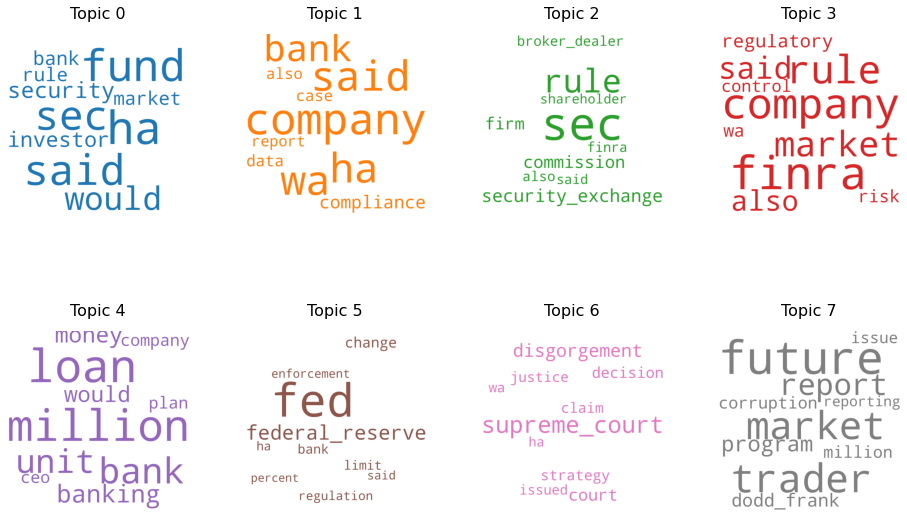

In [13]:
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors



cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1200,
                  height=1200,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16), y=1.05)
    plt.gca().axis('off')


plt.subplots_adjust(wspace=.3, hspace=.2)
plt.axis('off')
plt.margins(x=0, y=0)
#plt.tight_layout()
plt.show()

In [10]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.020578 -0.016639       1        1  29.973326
0      0.014347 -0.008634       2        1  22.740936
2      0.083206  0.018409       3        1  20.890574
3      0.047398  0.029953       4        1  10.231484
4     -0.051192 -0.075374       5        1   5.362922
5     -0.087288  0.077777       6        1   4.859269
7      0.008142 -0.040159       7        1   3.089170
6      0.005965  0.014666       8        1   2.852329, topic_info=              Term        Freq       Total Category  logprob  loglift
266            sec  318.000000  318.000000  Default  30.0000  30.0000
517            fed   54.000000   54.000000  Default  29.0000  29.0000
38         million  126.000000  126.000000  Default  28.0000  28.0000
465           loan   61.000000   61.000000  Default  27.0000  27.0000
514  supreme_court   44.000000   44.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
194           case    3.993588   96.047974   Topic8  -5.0263   0.3769
11             new    4.363685  135.234451   Topic8  -4.9377   0.1233
310          order    4.074627  111.234619   Topic8  -5.0062   0.2502
17            said    4.406725  272.989838   Topic8  -4.9279  -0.5693
111           bank    3.553594  180.818878   Topic8  -5.1431  -0.3725

[418 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
384       1  0.056441  according_sec
384       2  0.169323  according_sec
384       3  0.564410  according_sec
384       4  0.056441  according_sec
384       5  0.056441  according_sec
...     ...       ...            ...
124       4  0.055463           year
124       5  0.011093           year
124       6  0.077648           year
124       7  0.022185           year
124       8  0.011093           year

[1897 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5, 6, 8, 7])

* The area of circle represents the importance of each topic over the entire corpus
* The distance between the center of circles indicate the similarity between topics. 
* For each topic, the histogram on the right side listed the top 30 most relevant terms.

<br></br>
# 3. Select Keywords

<img src="images/Image 063.png">

#### Now, we have 8 groups of words. In this step, we select top 20 words from each group as our keywords 

In [14]:
x=lda_model.show_topics(num_words=20)

twords={}
for topic, word in x:
    twords[topic]=re.findall(r'\"(.*?)\"', word)
    
twords_df = pd.DataFrame(twords)
twords_df.columns = ['Topic '+str(i) for i in range(optimal_k)]
twords_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,ha,company,sec,finra,loan,fed,supreme_court,future
1,fund,said,rule,company,million,federal_reserve,disgorgement,trader
2,said,wa,security_exchange,rule,bank,change,court,market
3,sec,ha,commission,market,unit,bank,decision,report
4,would,bank,firm,said,banking,limit,strategy,program
5,security,compliance,also,also,money,regulation,claim,dodd_frank
6,investor,data,broker_dealer,regulatory,would,ha,justice,corruption
7,bank,case,finra,wa,company,said,wa,million
8,rule,also,said,risk,ceo,enforcement,issued,issue
9,market,report,shareholder,control,plan,percent,ha,reporting


### Build a feature dictionary

In [15]:
features = []

for words in twords.values():
    features.extend(words)
                                                # remove duplicated keywords
feature_dict = {word:i for i, word in enumerate(set(features))}
len(feature_dict)

98

<br></br>
# 4. Build Text Classification Model

<img src="images/Image 062.png">

Reference:
https://towardsdatascience.com/multi-class-text-classification-with-sklearn-and-nltk-in-python-a-software-engineering-use-case-779d4a28ba5

In [16]:
def featurize(texts, bigram_phrase, feature_dict):
    tokenized_docs = normalize_corpus(texts)
    bigram_texts = [bigram_phrase[line] for line in tokenized_docs]

    data = np.zeros((len(texts), len(feature_dict)))

    for i, text in enumerate(bigram_texts):
        for word in text:
            if word in feature_dict.keys():
                word_idx = feature_dict[word]
                data[i, word_idx] = 1
    
    return data

In [17]:
# Add non-compliance documents 
data = featurize(news_df['text'], bigram, feature_dict)

X = data
Y = news_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

pipeline = Pipeline([('clf', RandomForestClassifier())]) # Use Random Forest to identify topic 
model = pipeline.fit(X_train, y_train)

### Model Evaluation - Classification Report

In [18]:
ytest = np.array(y_test)
print(classification_report(ytest, model.predict(X_test)))

                precision    recall  f1-score   support

    Compliance       0.87      0.93      0.90       150
Non-Compliance       0.74      0.57      0.64        49

      accuracy                           0.84       199
     macro avg       0.80      0.75      0.77       199
  weighted avg       0.84      0.84      0.84       199



### Model Evaluation - Feature Importance

The link about chi-test feature selection:
https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223

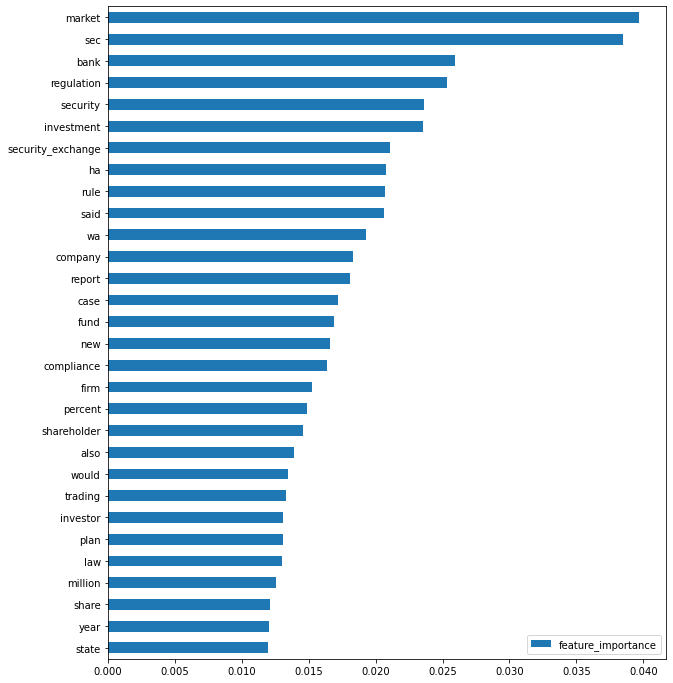

In [19]:
all_features = list(feature_dict.keys())
feature_importance = pd.DataFrame(model.steps[0][1].feature_importances_, index=all_features, columns=['feature_importance'])
feature_importance.sort_values('feature_importance').tail(30).plot.barh(figsize=[10,12])
plt.show()

### Model Evaluation - Apply the model to other unlabeld sources

In [20]:
forbes = "SEC Threatens Fines, Suspensions For Covid-19 Protocol Violations. Southeastern Conference Commissioner Greg Sankey sent a memo to the conference's football coaches and athletic directors last Wednesday, following the opening weekend of the SEC season, reminding coaches and players to wear masks on the sidelines, and followed up with another memo this week warning of possible fines and suspensions if protocols are violated."
nlr ="CCO Barred for Altering Reports to Mislead SEC Staff. Recently, the U.S. Securities and Exchange Commission (the “SEC”) charged a dually registered firm and its Chief Compliance Officer (“CCO”) with multiple violations of the Investment Advisers Act of 1940 (“Advisers Act”). The charges included allegations against the CCO that she altered documents in an attempt to mislead SEC examination staff and failures to comply with enhanced policies and procedures adopted as a result of a prior examination by FINRA. The SEC charged the firm with willfully violating Section 206(4) of the Advisers Act and Rule 206(4)-7 thereunder, which require, in part, that registered investment advisors “[a]dopt and implement written policies and procedures reasonably designed to prevent violation” of the Advisers Act and its rules. The CCO was charged with willfully aiding and abetting the firm’s violations. The firm and the CCO were fined $1.7 million and $45,000, respectively, and the CCO was barred from the industry."
fcpa = "Brazil holding company agrees to pay $285 million to settle FCPA violations. São Paulo-based conglomerate J&F Investimentos pleaded guilty Wednesday to conspiracy to violate the anti-bribery provisions of the Foreign Corrupt Practices Act for a scheme to bribe officials in Brazil."

new_data = pd.DataFrame([forbes, nlr, fcpa], columns=['text'])
print(model.predict(featurize(new_data['text'], bigram, feature_dict)))

['Compliance' 'Compliance' 'Compliance']


#### SEC articles

In [21]:
for word in all_features:
    if '_' in word:
        w1, w2 = word.split('_')
        all_features.append(w1)
        all_features.append(w2)
        all_features.remove(word)  

In [25]:
sec = pd.read_csv('data/SEC_articles.csv')
sec['text'] = sec['title'] + '. ' + sec['abstract']
sec['category_pred'] = model.predict(featurize(sec['text'], bigram, feature_dict))
prob = pd.DataFrame(model.predict_proba(featurize(sec['text'], bigram, feature_dict)), columns=model.steps[0][1].classes_).round(2)
sec['compliance_prob'] = prob['Compliance']

#nlp = en_core_web_lg.load()
keywords = nlp(' '.join(all_features))
all_news_list_token = [[token.lemma_.lower() for token in nlp(news) if token.pos_ in ['NOUN', 'PROPN']] for news in sec.text]
sec['similarity_score'] = [nlp(' '.join(news)).similarity(keywords) for news in all_news_list_token]

sec[['title', 'category_pred', 'compliance_prob', 'similarity_score']]

,title,category_pred,compliance_prob,similarity_score
0,SEC and CFTC to Hold a Joint Open Meeting on O...,Compliance,0.98,0.768393
1,SEC Charges Andeavor for Inadequate Controls A...,Compliance,0.80,0.911832
2,Board Member James G. Kaiser to Retire From th...,Compliance,0.93,0.822983
3,SEC Appoints PCAOB Chief Auditor Megan Zietsma...,Compliance,0.92,0.853091
4,"SEC Awards $800,000 to Whistleblower",Compliance,0.95,0.843519
5,SEC Charges Brazilian Meat Producers With FCPA...,Compliance,0.85,0.811206
6,Tamara Brightwell Named Deputy Director of Div...,Compliance,0.90,0.818999
7,Jessica Kane Named Director of Division of Cor...,Compliance,0.93,0.848751
8,"SEC Charges Seismic Data Company, Former Execu...",Compliance,0.83,0.892099
9,SEC Names Nichola L. Timmons Chief of New Offi...,Compliance,0.99,0.792011


# 5. Use Classifier or Similarity Score to Get More Compliance Articles

<img src="images/image_extra 511.png" width=1000>

In [11]:
google_news_finance = google_news_finance.dropna()
google_news_finance['category_pred'] = model.predict(featurize(google_news_finance['text'], bigram, feature_dict))
google_news_finance['category_pred'].value_counts()

NameError: name 'model' is not defined

In [34]:
for i, row in google_news_finance.loc[google_news_finance.category_pred == 'Compliance'].iloc[:10].iterrows():
    print(row['title'])

compliance
USOPC Announces Hiring Of Holly Shick As First Chief Ethics And Compliance Officer, Introduces New National Governing Body Audit Standards
compliance
Nevada OSHA issues 11 workplace citations, 9 for COVID-19 non compliance
compliance
St. Paul’s School compliance officer abruptly quits post
compliance
Australia's Westpac reveals findings from compliance review
compliance
Hong Kong financial firms step up compliance hiring amid U.S. sanctions, security law
compliance
Wells Fargo's chief compliance officer quits: FT
compliance
Compliance with legal requirement to report clinical trial results on ClinicalTrials.gov: a cohort study
compliance
Officials: 75% of Southern Nevada businesses in compliance with mask directive during July 1 inspections
compliance
Lower working memory capacity linked to non-compliance with social distancing guidelines during the early stage of the coronavirus outbreak
compliance
Citigroup chief compliance officer Mark Carawan retires


In [35]:
for i, row in google_news_finance.loc[google_news_finance.category_pred == 'Non-Compliance'].iloc[:10].iterrows():
    print(row['keyword'])
    print(row['title'])

cybersecurity
Health organizations responding to Covid-19 at risk from state-backed hackers, cybersecurity officials say
cybersecurity
The Cybersecurity 202: U.S. should brace for Iran to cross red lines in cyberspace, experts warn
cybersecurity
Report: Lax cybersecurity at CIA unit led to Vault 7 leaks -- FCW
cybersecurity
DHS cybersecurity agency warns of coronavirus phishing attacks
cybersecurity
Twitter hack probe leads to call for cybersecurity rules for social media giants – TechCrunch
cybersecurity
National Cybersecurity Awareness Month — FBI
cybersecurity
Congress, Warning of Cybersecurity Vulnerabilities, Recommends Overhaul
cybersecurity
Five cyber-security lessons from the pandemic
cybersecurity
The Cybersecurity 202: Election officials confident about security days before first contests of 2020
cybersecurity
FBI sees spike in cyber crime reports during coronavirus pandemic
